![img](https://drive.google.com/uc?export=view&id=1kgX98Ziw9LzgBCT2BxChttfrTcBltLej)




##### **MÓDULO 4: APLICACIONES INFORMÁTICAS**

##### **Integrantes:**

- Carolina Castelvetri
- Consuelo Nuñez
- Jorge Sarrouf
- Lucas Gette
- Martin Boccardo


----

## **Objetivo**

A partir de la información obtenida de la **Central de Deudores del BCRA**, nuestro objetivo es realizar un análisis exhaustivo de las personas que se encuentran dentro del dataset y poder realizar un clustering en base a los tipos de personas, al género en caso de la personas físicas, al monto de deuda, al tipo de entidad que otorgó el crédito y a si la deuda se encuentra en default o no. De esta manera buscamos conformar distintos grupos de deudores que nos permitan realizar comparaciones interesantes y útiles entre los mismos.


In [ ]:
#Librerías generales
import pandas as pd
import numpy as np


## Herramientas para graficar
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

# Import librerias para análisis de cluster
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score # otra manera de medir la cantidad de clusters

## Barras de progreso en los iteradores
from tqdm.notebook import tqdm

In [ ]:
#Leemos el dataset
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/TP4 - Grupo 10/Archivos limpios/bcra_procesado.csv")
df.head(4) 

Mounted at /content/drive


,fecha_informacion,cuit,E1_D,E2_D,E3_D,E4_D,E5_D,E6_D,E1_Ok,E2_Ok,E3_Ok,E4_Ok,E5_Ok,E6_Ok,deuda_total,garantias,mujer,empresa,hombre,default,deuda_default,deuda_ok
0,202108,20000079643,0,0,0,0,0,16,0,0,0,0,0,0,16,0,0,0,1,1,16,0
1,202108,20000110680,0,0,0,0,0,0,3,0,0,0,0,0,3,0,0,0,1,0,0,3
2,202108,20000143368,0,0,0,0,0,0,11,0,0,0,0,0,11,0,0,0,1,0,0,11
3,202108,20000297713,0,0,0,0,0,0,0,0,67,0,0,0,67,0,0,0,1,0,0,67


In [ ]:
df.shape

(3000000, 22)

Transformamos la deuda de cada tipo de empresa en la proporcion del total

In [ ]:
df['E1_Ok'] = df['E1_Ok']/df['deuda_total']
df['E2_Ok'] = df['E2_Ok']/df['deuda_total']
df['E3_Ok'] = df['E3_Ok']/df['deuda_total']
df['E4_Ok'] = df['E4_Ok']/df['deuda_total']
df['E5_Ok'] = df['E5_Ok']/df['deuda_total']
df['E6_Ok'] = df['E6_Ok']/df['deuda_total']
df['E1_D'] = df['E1_D']/df['deuda_total']
df['E2_D'] = df['E2_D']/df['deuda_total']
df['E3_D'] = df['E3_D']/df['deuda_total']
df['E4_D'] = df['E4_D']/df['deuda_total']
df['E5_D'] = df['E5_D']/df['deuda_total']
df['E6_D'] = df['E6_D']/df['deuda_total']
df['deuda_default'] = df['deuda_default']/df['deuda_total']
df['deuda_ok'] = df['deuda_ok']/df['deuda_total']

df.head(4)

,fecha_informacion,cuit,E1_D,E2_D,E3_D,E4_D,E5_D,E6_D,E1_Ok,E2_Ok,E3_Ok,E4_Ok,E5_Ok,E6_Ok,deuda_total,garantias,mujer,empresa,hombre,default,deuda_default,deuda_ok
0,202108,20000079643,0.0,0.0,0.0,0.0,0.0,0.0625,0.000000,0.0,0.000000,0.0,0.0,0.0,16,0,0,0,1,1,0.0625,0.000000
1,202108,20000110680,0.0,0.0,0.0,0.0,0.0,0.0000,0.333333,0.0,0.000000,0.0,0.0,0.0,3,0,0,0,1,0,0.0000,0.333333
2,202108,20000143368,0.0,0.0,0.0,0.0,0.0,0.0000,0.090909,0.0,0.000000,0.0,0.0,0.0,11,0,0,0,1,0,0.0000,0.090909
3,202108,20000297713,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.014925,0.0,0.0,0.0,67,0,0,0,1,0,0.0000,0.014925


In [ ]:
#Para el modelado no es necesaria la información de  cuit y periodo
df_kmean = df.drop(['fecha_informacion','cuit'], axis = 1)

In [ ]:
#Escalamos solo la variable deuda. Al resto no debido a que son dummies o valores bajos.
std_scaler = StandardScaler()
scaled_features = std_scaler.fit_transform(df_kmean['deuda_total'].to_frame())
df_scaled = df_kmean.join(pd.DataFrame(scaled_features, index=df_kmean.index, columns=['deuda_total_escalada']))
df_scaled = df_scaled.drop('deuda_total',1)
df_scaled.head(3)

,E1_D,E2_D,E3_D,E4_D,E5_D,E6_D,E1_Ok,E2_Ok,E3_Ok,E4_Ok,E5_Ok,E6_Ok,garantias,mujer,empresa,hombre,default,deuda_default,deuda_ok,deuda_total_escalada
0,0.0,0.0,0.0,0.0,0.0,0.0625,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0.0625,0.000000,-0.009112
1,0.0,0.0,0.0,0.0,0.0,0.0000,0.333333,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0.0000,0.333333,-0.009512
2,0.0,0.0,0.0,0.0,0.0,0.0000,0.090909,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0.0000,0.090909,-0.009266


Utilizamos la técnica Elbow para determinar el número de cluster a utilizar en nuestro modelo.

  0%|          | 0/29 [00:00<?, ?it/s]

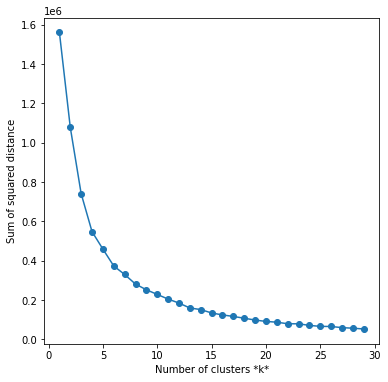

In [ ]:
#elbow para ver cuantos grupos podemos tener
# Tarda en correr
sse = []
df_sample = df_scaled.sample(1000000)
list_k = list(range(1, 30))

for k in tqdm(list_k):
    km = KMeans(n_clusters=k)
    km.fit(df_sample)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

Si bien vemos mejoras posibles con un número alto de cluster, para un análisis inicial, seleccionamos 9 grupos para el modelado final

In [ ]:
#Entrenamos el modelo final 
kmeans = KMeans(n_clusters=9, max_iter=30)
kmeans.fit(df_scaled)

KMeans(max_iter=30, n_clusters=9)

Generamos el modelo y lo guardamos para analizarlo sin cambios

In [ ]:
# # GENERA EL MODELO y lo guarda para poder levantarlo y que no cambien los clusters
# # save the model to disk
# import joblib
# filename = 'finalized_model.sav'
# joblib.dump(kmeans, filename) 

# from google.colab import files
# !cp finalized_model.sav "/content/drive/My Drive/"

In [ ]:
# Levanta el modelo para que siempre sea el mismo 9 clusters, 30 iter
import joblib
kmeans = joblib.load("/content/drive/MyDrive/TP4 - Grupo 10/Archivos limpios/finalized_model.sav")


Analizamos un poco cada cluster para encontrar caracteristicas comunes 

In [ ]:
#Pegamos las etiquetas del modelo en nuestro dataframe para estudiar los grupos
df['grupo'] = kmeans.labels_
df.groupby('grupo').size()

grupo
0    269618
1    843515
2    313746
3         2
4    924476
5     72646
6    269833
7        10
8    306154
dtype: int64

In [ ]:
df.groupby('grupo').size().to_frame()

,0
grupo,
0,269618
1,843515
2,313746
3,2
4,924476
5,72646
6,269833
7,10
8,306154


In [ ]:
df.head()

,fecha_informacion,cuit,E1_D,E2_D,E3_D,E4_D,E5_D,E6_D,E1_Ok,E2_Ok,E3_Ok,E4_Ok,E5_Ok,E6_Ok,deuda_total,garantias,mujer,empresa,hombre,default,deuda_default,deuda_ok,grupo
0,202108,20000079643,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16,0,0,0,1,1,1.0,0.0,2
1,202108,20000110680,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,0,0,0,1,0,0.0,1.0,4
2,202108,20000143368,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11,0,0,0,1,0,0.0,1.0,4
3,202108,20000297713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,67,0,0,0,1,0,0.0,1.0,0
4,202108,20000788261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,9,0,0,0,1,0,0.0,1.0,0


Observamos la distribución de la deuda total por grupo

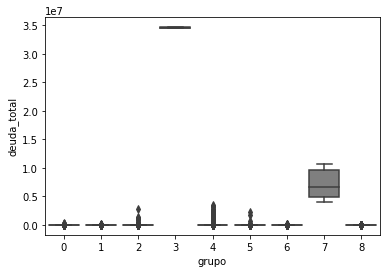

In [ ]:
# Box plot Deuda total

sns.boxplot(x='grupo', y='deuda_total', data=df)

In [ ]:
df2 = df[(df['grupo'] != 3) & (df['grupo'] != 7) ].reset_index()

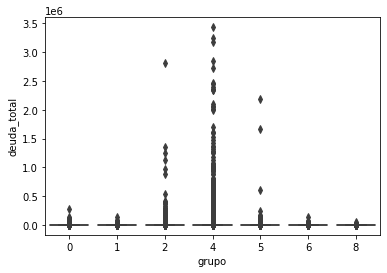

In [ ]:
# Box plot Deuda total sin empresas

sns.boxplot(x='grupo', y='deuda_total', data=df2)

In [ ]:
#
df['E1'] = df['E1_Ok'] + df['E1_D']
df['E2'] = df['E2_Ok'] + df['E2_D']
df['E3'] = df['E3_Ok'] + df['E3_D']
df['E4'] = df['E4_Ok'] + df['E4_D']
df['E5'] = df['E5_Ok'] + df['E5_D']
df['E6'] = df['E6_Ok'] + df['E6_D']

In [ ]:
df.head()

,fecha_informacion,cuit,E1_D,E2_D,E3_D,E4_D,E5_D,E6_D,E1_Ok,E2_Ok,E3_Ok,E4_Ok,E5_Ok,E6_Ok,deuda_total,garantias,mujer,empresa,hombre,default,deuda_default,deuda_ok,grupo,E1,E2,E3,E4,E5,E6
0,202108,20000079643,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16,0,0,0,1,1,1.0,0.0,2,0.0,0.0,0.0,0.0,0.0,1.0
1,202108,20000110680,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,0,0,0,1,0,0.0,1.0,4,1.0,0.0,0.0,0.0,0.0,0.0
2,202108,20000143368,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11,0,0,0,1,0,0.0,1.0,4,1.0,0.0,0.0,0.0,0.0,0.0
3,202108,20000297713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,67,0,0,0,1,0,0.0,1.0,0,0.0,0.0,1.0,0.0,0.0,0.0
4,202108,20000788261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,9,0,0,0,1,0,0.0,1.0,0,0.0,0.0,1.0,0.0,0.0,0.0


Agrupamos la información de cada segmento para obtener las características principales de cada uno

In [ ]:

def lam1(x):
    return np.percentile(x, 25).round(2)

def lam2(x):
    return np.percentile(x, 75).round(2)

dic_func = {'deuda_total': [np.sum ,np.mean, np.min, np.max,lam1,lam2,np.median],
            'garantias': np.mean,
            'mujer': [np.mean,np.sum],
            'hombre': [np.mean,np.sum],
            'empresa': [np.mean,np.sum],
            'deuda_default' : np.mean,
            'deuda_ok' : np.mean,
            'E1' : np.mean,
            'E2' : np.mean,
            'E3' : np.mean,
            'E4' : np.mean,
            'E5' : np.mean,
            'E6' : np.mean
            }

table = pd.pivot_table(df, values=['deuda_total','garantias','mujer','hombre','empresa','deuda_default','deuda_ok','E1','E2','E3','E4','E5','E6'], index=['grupo'],
                    aggfunc=dic_func )



In [ ]:
table.round(2)

E1    E2    E3    E4    E5  ... garantias hombre           mujer          
       mean  mean  mean  mean  mean  ...      mean   mean       sum  mean       sum
grupo                                ...                                           
0      0.09  0.05  0.71  0.02  0.01  ...      0.04   0.99  267987.0  0.00       0.0
1      0.95  0.01  0.03  0.00  0.00  ...      0.07   0.00       0.0  1.00  843515.0
2      0.48  0.17  0.21  0.00  0.00  ...      0.30   0.98  306413.0  0.00       0.0
3      1.00  0.00  0.00  0.00  0.00  ...      1.00   0.00       0.0  0.00       0.0
4      0.96  0.00  0.03  0.00  0.00  ...      0.11   0.96  884141.0  0.00       0.0
5      0.29  0.20  0.29  0.00  0.01  ...      0.56   0.54   39221.0  0.45   32809.0
6      0.44  0.19  0.24  0.00  0.00  ...      0.26   0.00       0.0  0.99  267469.0
7      1.00  0.00  0.00  0.00  0.00  ...      0.70   0.00       0.0  0.00       0.0
8      0.09  0.05  0.74  0.01  0.01  ...      0.02   0.00       0.0  0.99  303319.0

[9 rows x 22 columns]

In [ ]:
table = table.set_axis(['E1','E2','E3','E4','E5','E6','deuda_default','deuda_ok','deuda_total_max','deuda_total_min',
                              'deuda_total_q1','deuda_total_q3','deuda_total_mean','deuda_total_median','deuda_total_sum','empresa_mean','empresa_cant', 'garantias',
                        'hombre_mean','hombre_cant','mujer_mean','mujer_cant'],axis=1)

In [ ]:
table.round(2)

,E1,E2,E3,E4,E5,E6,deuda_default,deuda_ok,deuda_total_max,deuda_total_min,deuda_total_q1,deuda_total_q3,deuda_total_mean,deuda_total_median,deuda_total_sum,empresa_mean,empresa_cant,garantias,hombre_mean,hombre_cant,mujer_mean,mujer_cant
grupo,,,,,,,,,,,,,,,,,,,,,,
0,0.09,0.05,0.71,0.02,0.01,0.13,0.0,1.0,273170.0,1.0,20.00,110.00,117.44,49.0,31664460.0,0.00,960.0,0.04,0.99,267987.0,0.00,0.0
1,0.95,0.01,0.03,0.00,0.00,0.01,0.0,1.0,145924.0,1.0,25.00,166.00,182.82,70.0,154214809.0,0.00,0.0,0.07,0.00,0.0,1.00,843515.0
2,0.48,0.17,0.21,0.00,0.00,0.12,1.0,0.0,2814165.0,1.0,6.00,89.00,190.72,25.0,59837001.0,0.02,5647.0,0.30,0.98,306413.0,0.00,0.0
3,1.00,0.00,0.00,0.00,0.00,0.00,0.5,0.5,34687819.0,34552258.0,34586148.25,34653928.75,34620038.50,34620038.5,69240077.0,1.00,2.0,1.00,0.00,0.0,0.00,0.0
4,0.96,0.00,0.03,0.00,0.00,0.01,0.0,1.0,3434839.0,1.0,33.00,227.00,525.55,91.0,485857944.0,0.03,30198.0,0.11,0.96,884141.0,0.00,0.0
5,0.29,0.20,0.29,0.00,0.01,0.21,1.0,0.0,2184864.0,3.0,44.00,194.00,273.77,91.0,19888323.0,0.00,306.0,0.56,0.54,39221.0,0.45,32809.0
6,0.44,0.19,0.24,0.00,0.00,0.12,1.0,0.0,130623.0,1.0,6.00,78.00,84.06,22.0,22682668.0,0.00,521.0,0.26,0.00,0.0,0.99,267469.0
7,1.00,0.00,0.00,0.00,0.00,0.00,0.0,1.0,10704946.0,4044024.0,4833726.25,9714044.25,7096322.80,6654037.5,70963228.0,1.00,10.0,0.70,0.00,0.0,0.00,0.0
8,0.09,0.05,0.74,0.01,0.01,0.10,0.0,1.0,49446.0,1.0,16.00,87.00,74.31,40.0,22750093.0,0.00,765.0,0.02,0.00,0.0,0.99,303319.0


In [ ]:
# Para sacar a los grandes deudores y entender la compo de deuda de los otros segmentos mejor
df_new = df[(df['grupo'] != 3) & (df['grupo'] != 7) ].reset_index()

std_scaler2 = StandardScaler()
df_new['deuda_total_escalada'] = std_scaler2.fit_transform(df_new['deuda_total'].to_frame())

dic_func2 = {'deuda_total': [np.sum ,np.mean, np.max,lam1,lam2,np.median],
             'deuda_total_escalada': [np.sum ,np.max,np.mean]
            }

table2 = pd.pivot_table(df_new, values=['deuda_total','deuda_total_escalada'], index=['grupo'],
                    aggfunc=dic_func2)

table2 = table2.set_axis(['deuda_total_max','deuda_total_q1','deuda_total_q3','deuda_total_mean','deuda_total_median','deuda_total_sum','deuda_total_escalda_max','deuda_total_escalda_mean','deuda_total_escalda_sum'],axis=1)

table2.sort_values('deuda_total_escalda_mean', ascending=False).round(2)


,deuda_total_max,deuda_total_q1,deuda_total_q3,deuda_total_mean,deuda_total_median,deuda_total_sum,deuda_total_escalda_max,deuda_total_escalda_mean,deuda_total_escalda_sum
grupo,,,,,,,,,
4,3434839.0,33.0,227.0,525.55,91.0,485857944.0,410.24,0.03,28701.20
5,2184864.0,44.0,194.0,273.77,91.0,19888323.0,260.94,0.00,70.61
2,2814165.0,6.0,89.0,190.72,25.0,59837001.0,336.11,-0.01,-2807.48
1,145924.0,25.0,166.0,182.82,70.0,154214809.0,17.40,-0.01,-8343.33
0,273170.0,20.0,110.0,117.44,49.0,31664460.0,32.60,-0.02,-4772.44
6,130623.0,6.0,78.0,84.06,22.0,22682668.0,15.57,-0.02,-5852.10
8,49446.0,16.0,87.0,74.31,40.0,22750093.0,5.87,-0.02,-6996.46


Tambien utilizamos la información de los centroides

In [ ]:
pd.DataFrame(kmeans.cluster_centers_,columns = kmeans.feature_names_in_).round(2)

,E1_D,E2_D,E3_D,E4_D,E5_D,E6_D,E1_Ok,E2_Ok,E3_Ok,E4_Ok,E5_Ok,E6_Ok,garantias,mujer,empresa,hombre,default,deuda_default,deuda_ok,deuda_total_escalada
0,-0.00,0.00,0.00,-0.0,-0.00,-0.00,0.09,0.05,0.71,0.02,0.01,0.13,0.04,0.00,0.00,0.99,-0.00,0.0,1.0,-0.01
1,0.00,-0.00,-0.00,0.0,-0.00,0.00,0.95,0.01,0.03,0.00,0.00,0.01,0.07,1.00,0.00,-0.00,-0.00,0.0,1.0,-0.00
2,0.35,0.17,0.17,0.0,0.00,0.11,0.14,0.01,0.04,0.00,0.00,0.02,0.30,0.00,0.02,0.98,1.19,1.0,-0.0,-0.00
3,0.50,0.00,0.00,0.0,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,6.00,0.5,0.5,1064.41
4,0.00,-0.00,-0.00,0.0,-0.00,-0.00,0.96,0.00,0.03,0.00,0.00,0.01,0.11,-0.00,0.03,0.96,-0.00,0.0,1.0,0.01
5,0.24,0.19,0.28,0.0,0.01,0.20,0.05,0.00,0.01,0.00,0.00,0.02,0.56,0.45,0.00,0.54,3.73,1.0,0.0,-0.00
6,0.28,0.18,0.19,0.0,0.00,0.10,0.16,0.01,0.05,0.00,0.00,0.02,0.26,0.99,0.00,0.00,1.18,1.0,-0.0,-0.01
7,0.00,-0.00,0.00,-0.0,0.00,-0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.70,0.00,1.00,-0.00,-0.00,0.0,1.0,218.17
8,0.00,0.00,0.00,-0.0,-0.00,-0.00,0.09,0.05,0.74,0.01,0.01,0.10,0.02,0.99,0.00,0.00,-0.00,0.0,1.0,-0.01


Características de los clusters:

* **Cluster 0:** principalmente hombres, con buen comportamiento (sin default), con deuda media de 117 mil que utilizan principalmente entidades 3 para operar.

* **Cluster 1:** mujeres con buen comportamiento, con deuda media de 182 mil que utilizan principalmente entidades 1 para operar.

* **Cluster 2:** principalmente hombres, con un promedio de $190mil en default, utilizan principalmente entidades 1 para operar, pero se 

* **Cluster 3:** compuesto por las dos empresas (YPF y Vicentín) que poseen el nivel de deuda más alto del país (34 mil millones de pesos cada una aproximadamente). La diferencia entre sí es que la segunda posee toda su deuda en default.

* **Cluster 4:** Hombre y Empresas con buen comportamiento que prefieren entidades tipo 1 y tienen un promedio alto de endudamiento 525mil

* **Cluster 5:** mujeres y hombres en default practicamente en todos los tipos de entidades.273 deuda media

* **Cluster 6:** principalmente mujeres, con default, pero bajo importe media de deuda 84.

* **Cluster 7:** empresas con alto  nivel de deuda , sin default y alto nivel de garantias.

* **Cluster 8:** principalmente mujeres con buen comportamiento, bajo nivel de endeudamiento que utilizan principalmente entidad 3 para financiarse








<function matplotlib.pyplot.legend>

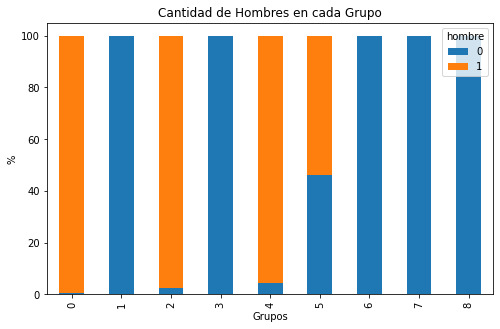

In [ ]:
#% de Hombres en cada grupo
pd.crosstab(index=df['grupo'],
            columns=df['hombre']
                  ).apply(lambda r: r/r.sum()*100,
                          axis=1).plot(kind='bar', stacked=True,figsize=(8,5))
plt.title("Cantidad de Hombres en cada Grupo")
plt.xlabel("Grupos")
plt.ylabel("%")
plt.legend

<function matplotlib.pyplot.legend>

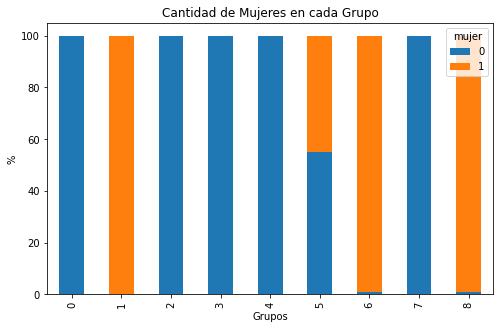

In [ ]:
#% de Mujeres en cada grupo
pd.crosstab(index=df['grupo'],
            columns=df['mujer']
                  ).apply(lambda r: r/r.sum()*100,
                          axis=1).plot(kind='bar', stacked=True,figsize=(8,5))
plt.title("Cantidad de Mujeres en cada Grupo")
plt.xlabel("Grupos")
plt.ylabel("%")
plt.legend

<function matplotlib.pyplot.legend>

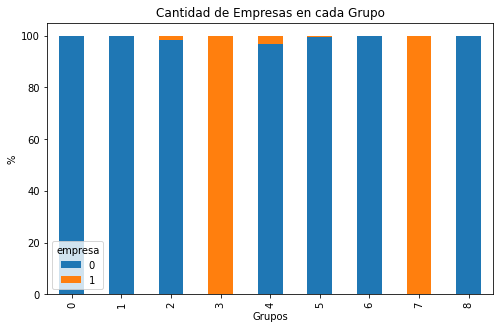

In [ ]:
#% de Empresas en cada grupo
pd.crosstab(index=df['grupo'],
            columns=df['empresa']
                  ).apply(lambda r: r/r.sum()*100,
                          axis=1).plot(kind='bar', stacked=True,figsize=(8,5))
plt.title("Cantidad de Empresas en cada Grupo")
plt.xlabel("Grupos")
plt.ylabel("%")
plt.legend

In [ ]:
df_agrupado = df.groupby(['grupo']).deuda_total.sum().to_frame().reset_index()

In [ ]:
df_agrupado

,grupo,deuda_total
0,0,31664460
1,1,154214809
2,2,59837001
3,3,69240077
4,4,485857944
5,5,19888323
6,6,22682668
7,7,70963228
8,8,22750093


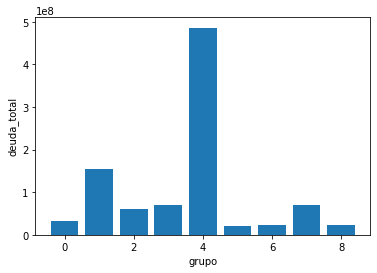

In [ ]:
#Gráficamos la variable objetivo  
plt.bar(df_agrupado["grupo"],df_agrupado["deuda_total"])
plt.xlabel("grupo")
plt.ylabel("deuda_total")
plt.show()

In [ ]:
df_agrupado1 = df.groupby(['grupo']).deuda_total.mean().to_frame().reset_index()

In [ ]:

df_agrupado1.round(2)

,grupo,deuda_total
0,0,117.44
1,1,182.82
2,2,190.72
3,3,34620038.50
4,4,525.55
5,5,273.77
6,6,84.06
7,7,7096322.80
8,8,74.31


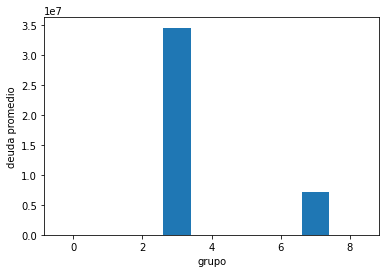

In [ ]:
#Gráficamos la variable objetivo  
plt.bar(df_agrupado1["grupo"],df_agrupado1["deuda_total"])
plt.xlabel("grupo")
plt.ylabel("deuda promedio")
plt.show()

In [ ]:
agrupado1b = df_agrupado1[(df_agrupado1['grupo']!=3) & (df_agrupado1['grupo']!=7)]
agrupado1b

,grupo,deuda_total
0,0,117.441936
1,1,182.824027
2,2,190.717973
4,4,525.549548
5,5,273.770380
6,6,84.061875
8,8,74.309312


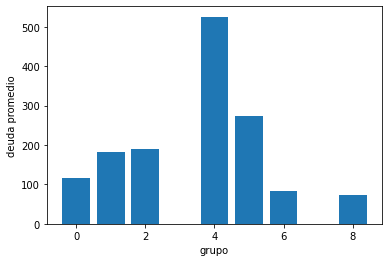

In [ ]:
#Gráficamos la variable objetivo  
plt.bar(agrupado1b["grupo"],agrupado1b["deuda_total"])
plt.xlabel("grupo")
plt.ylabel("deuda promedio")
plt.show()